<a href="https://colab.research.google.com/github/carlosarturoceron/dataKids/blob/main/Titanic_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Datos de Kaggle

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3136%2F26502%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240506%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240506T063649Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da395ad09669e941fda5fe3f2dbd6a73b156a1442368b663ef29bd0566ff29c1b1aaad0ad5b8585bbaa6ebfb84c2f06eb4c9c1caf6a11644003884714328d248092173b68466a71c59a99671fcef44303364b2462666a8a9b7345814b37bef6cc0b1687418021e606b7660d3e876c83f32c9cb70323404ae466d4dd81a3c658c8203b3d62fe86ebee1c79492e3bfc81e9db9c2c6fc58549ec90704e21539ce897b805e358f665867c95dff514885c46a155dfcd1f932784bcaa17cf49fd372f53569688a274269fb7fc48130efa8c0f082cffcd6aa228fc4fd2d890e2accf8cf5ba2d36f03299867b4a4a6dffebcec34bc90140713fc842b9bbf7f95a6ac83d58'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')
t

[==================================================] 34877 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


# Prediciendo la supervivencia en el Titanic

### Contenidos:
1. Importar Bibliotecas Necesarias
2. Leer y Explorar los Datos
3. Análisis de Datos
4. Visualización de Datos
5. Limpieza de Datos
6. Elección del Mejor Modelo
7. Creación del Archivo de Envío


Descripción del conjunto de datos

Visión general

Los datos se han dividido en dos grupos:

Conjunto de entrenamiento (train.csv)
Conjunto de prueba (test.csv)

El conjunto de entrenamiento debe utilizarse para construir sus modelos de aprendizaje automático. Para el conjunto de entrenamiento, proporcionamos el resultado (también conocido como "verdad fundamental") para cada pasajero. Su modelo se basará en "características" como el género y la clase de los pasajeros. También puede utilizar la ingeniería de características para crear nuevas características.

El conjunto de pruebas debe utilizarse para ver qué tan bien funciona su modelo en datos no vistos. Para el conjunto de pruebas, no proporcionamos la verdad fundamental para cada pasajero. Es su trabajo predecir estos resultados. Para cada pasajero en el conjunto de pruebas, use el modelo que entrenó para predecir si sobrevivieron o no al hundimiento del Titanic.

## Importar Bibliotecas Necesarias

Primero, necesitamos importar varias bibliotecas de Python como numpy, pandas, matplotlib y seaborn.


In [2]:
# Bibliotecas de análisis de datos
import numpy as np
import pandas as pd

# Bibliotecas de visualización
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Ignorar advertencias
import warnings
warnings.filterwarnings('ignore')


## 2) Leer y Explorar los Datos

Es el momento de leer nuestros datos de entrenamiento y prueba utilizando `pd.read_csv`, y echar un primer vistazo a los datos de entrenamiento usando la función `describe()`.


In [3]:
# Importar archivos CSV de entrenamiento y prueba
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

# Echar un vistazo a los datos de entrenamiento
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 3) Análisis de Datos

Vamos a considerar las características en el conjunto de datos y qué tan completas están.


In [4]:
# obtener una lista de las columnas del conjunto de datos
print(train.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [5]:
# ver una muestra del conjunto de datos
train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
763,764,1,1,"Carter, Mrs. William Ernest (Lucile Polk)",female,36.0,1,2,113760,120.0000,B96 B98,S
827,828,1,2,"Mallet, Master. Andre",male,1.0,0,2,S.C./PARIS 2079,37.0042,NaN,C
833,834,0,3,"Augustsson, Mr. Albert",male,23.0,0,0,347468,7.8542,NaN,S
146,147,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
850,851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.2750,NaN,S


* **Características Numéricas:** Edad (Continuo), Tarifa (Continuo), SibSp (Discreto), Parch (Discreto)
* **Características Categóricas:** Supervivencia, Género, Embarcado, Clase
* **Características Alfanuméricas:** Boleto, Cabina

### ¿Cuáles son los tipos de datos para cada característica?

* Supervivencia: entero
* Clase: entero
* Nombre: cadena
* Género: cadena
* Edad: flotante
* Conyuge/Hermano: entero
* Padres/Hijos: entero
* Boleto: cadena
* Tarifa: flotante
* Cabina: cadena
* Embarcado: cadena

Ahora que tenemos una idea de qué tipos de características estamos trabajando, podemos ver cuánta información tenemos sobre cada una de ellas.


In [6]:
#see a summary of the training dataset
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
#check for any other unusable values
print(pd.isnull(train).sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Algunas Observaciones:
* Hay un total de 891 pasajeros en nuestro conjunto de entrenamiento.
* La característica Edad faltan aproximadamente el 19.8% de sus valores. Supongo que la característica Edad es bastante importante para la supervivencia, así que probablemente deberíamos intentar llenar estos vacíos.
* La característica Cabina falta aproximadamente el 77.1% de sus valores. Dado que falta gran parte de la característica, sería difícil completar los valores faltantes. Probablemente eliminaremos estos valores de nuestro conjunto de datos.
* La característica Embarcado falta el 0.22% de sus valores, lo que debería ser relativamente inofensivo.

Algunas Predicciones:

* Género: Las mujeres tienen más probabilidades de sobrevivir.
* ConyugeHermano/PadresHijos: Las personas que viajan solas tienen más probabilidades de sobrevivir.
* Edad: Los niños pequeños tienen más probabilidades de sobrevivir.
* Clase: Las personas de una clase socioeconómica más alta tienen más probabilidades de sobrevivir.


## Visualizacion de datos

### Género

Porcentaje de mujeres que sobrevivieron: 74.20382165605095
Porcentaje de hombres que sobrevivieron: 18.890814558058924


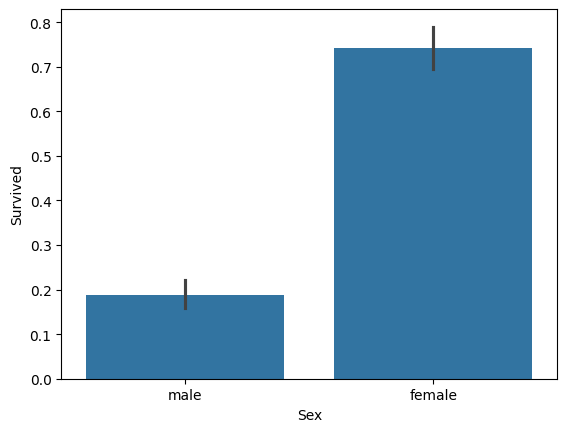

In [8]:
# Dibujar un gráfico de barras de supervivencia por Género
sns.barplot(x="Sex", y="Survived", data=train)

# Imprimir porcentajes de mujeres y hombres que sobreviven
print("Porcentaje de mujeres que sobrevivieron:", train["Survived"][train["Sex"] == 'female'].value_counts(normalize = True)[1]*100)

print("Porcentaje de hombres que sobrevivieron:", train["Survived"][train["Sex"] == 'male'].value_counts(normalize = True)[1]*100)

Así como se predijo, las mujeres tienen muchas más probabilidades de sobrevivir que los hombres. La característica de Género es esencial en nuestras predicciones.

### Carácteristica de Clase

Porcentaje de Pclass = 1 que sobrevivieron: 62.96296296296296
Porcentaje de Pclass = 2 que sobrevivieron: 47.28260869565217
Porcentaje de Pclass = 3 que sobrevivieron: 24.236252545824847


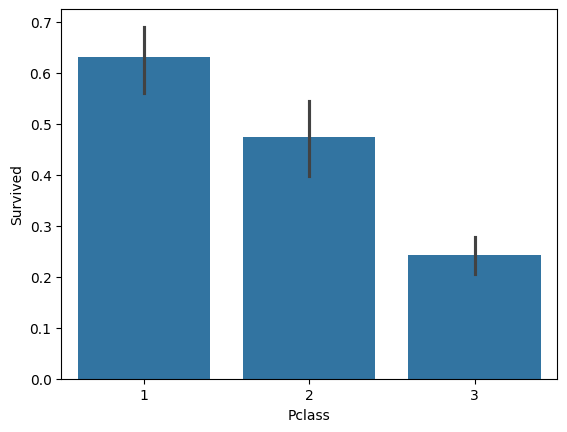

In [9]:
# Dibujar un gráfico de barras de supervivencia por Clase
sns.barplot(x="Pclass", y="Survived", data=train)

# Imprimir porcentaje de personas por Clase que sobrevivieron
print("Porcentaje de Pclass = 1 que sobrevivieron:", train["Survived"][train["Pclass"] == 1].value_counts(normalize = True)[1]*100)

print("Porcentaje de Pclass = 2 que sobrevivieron:", train["Survived"][train["Pclass"] == 2].value_counts(normalize = True)[1]*100)

print("Porcentaje de Pclass = 3 que sobrevivieron:", train["Survived"][train["Pclass"] == 3].value_counts(normalize = True)[1]*100)

Como se predijo, las personas con una clase socioeconómica más alta tuvieron una tasa de supervivencia más alta. (62.9% vs. 47.3% vs. 24.2%)

### Caracteristica Conyugue/Hermanos

Porcentaje de SibSp = 0 que sobrevivieron: 34.53947368421053
Porcentaje de SibSp = 1 que sobrevivieron: 53.588516746411486
Porcentaje de SibSp = 2 que sobrevivieron: 46.42857142857143


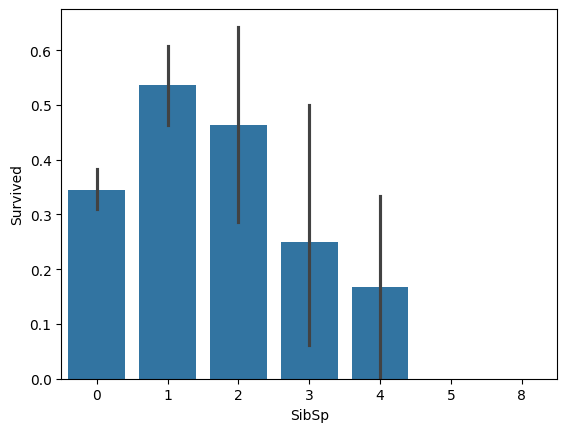

In [10]:
# Dibujar un gráfico de barras para Conyuge/Hermano vs. supervivencia
sns.barplot(x="SibSp", y="Survived", data=train)

# No imprimiré valores porcentuales individuales para todos estos.
print("Porcentaje de SibSp = 0 que sobrevivieron:", train["Survived"][train["SibSp"] == 0].value_counts(normalize = True)[1]*100)

print("Porcentaje de SibSp = 1 que sobrevivieron:", train["Survived"][train["SibSp"] == 1].value_counts(normalize = True)[1]*100)

print("Porcentaje de SibSp = 2 que sobrevivieron:", train["Survived"][train["SibSp"] == 2].value_counts(normalize = True)[1]*100)

En general, está claro que las personas con más hermanos o cónyuges a bordo tenían menos probabilidades de sobrevivir. Sin embargo, contrariamente a las expectativas, las personas sin hermanos ni cónyuges tenían menos probabilidades de sobrevivir que aquellas con uno o dos. (34.5% vs 53.4% vs. 46.4%)

### Carácteristica PadresHijos

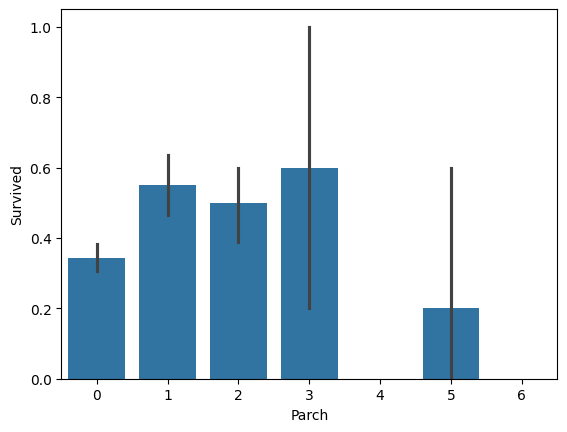

In [11]:
# Dibujar un gráfico de barras para Parch vs. supervivencia
sns.barplot(x="Parch", y="Survived", data=train)
plt.show()

Las personas con menos de cuatro padres o hijos a bordo tienen más probabilidades de sobrevivir que aquellos con cuatro o más. Nuevamente, las personas que viajan solas tienen menos probabilidades de sobrevivir que aquellas con 1-3 padres o hijos.

### Edad

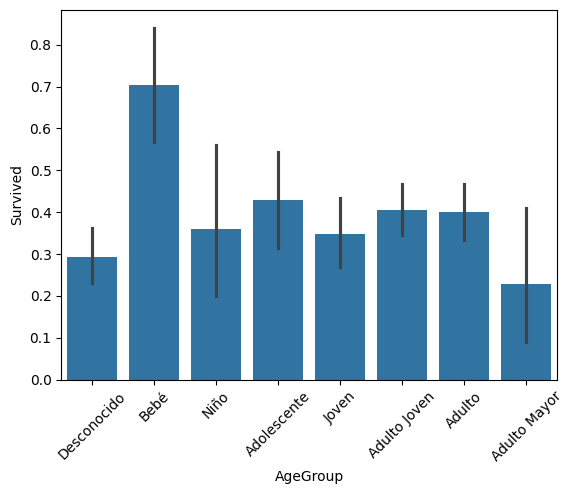

In [12]:
# Clasificar las edades en categorías lógicas
train["Age"] = train["Age"].fillna(-0.5)
test["Age"] = test["Age"].fillna(-0.5)
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Desconocido', 'Bebé', 'Niño', 'Adolescente', 'Joven', 'Adulto Joven', 'Adulto', 'Adulto Mayor']
train['AgeGroup'] = pd.cut(train["Age"], bins, labels=labels)
test['AgeGroup'] = pd.cut(test["Age"], bins, labels=labels)

# Dibujar un gráfico de barras de Edad vs. supervivencia
sns.barplot(x="AgeGroup", y="Survived", data=train)
plt.xticks(rotation=45)
plt.show()

Los bebés sobrevivieron más que cualquier otro grupo de edad

### Característica de Cabina

HIPOTESIS: que las personas con números de cabina registrados pertenecen a una clase socioeconómica más alta y, por lo tanto, tienen más probabilidades de sobrevivir.

Porcentaje de CabinBool = 1 que sobrevivieron: 66.66666666666666
Porcentaje de CabinBool = 0 que sobrevivieron: 29.985443959243085


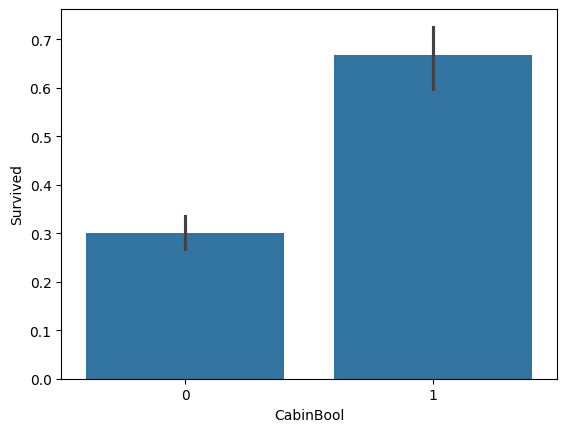

In [13]:
train["CabinBool"] = (train["Cabin"].notnull().astype('int'))
test["CabinBool"] = (test["Cabin"].notnull().astype('int'))

# Calcular porcentajes de CabinBool vs. sobrevivieron
print("Porcentaje de CabinBool = 1 que sobrevivieron:", train["Survived"][train["CabinBool"] == 1].value_counts(1)[1]*100)

print("Porcentaje de CabinBool = 0 que sobrevivieron:", train["Survived"][train["CabinBool"] == 0].value_counts(1)[1]*100)

# Dibujar un gráfico de barras de CabinBool vs. supervivencia
sns.barplot(x="CabinBool", y="Survived", data=train)
plt.show()

Las personas con un número de cabina registrado, de hecho, tienen más probabilidades de sobrevivir. (66.6% vs 29.9%)

## Limpiar los Datos

¡Es hora de limpiar nuestros datos para tener en cuenta los valores faltantes y la información innecesaria!

### Analizando los Datos de Prueba

¡Veamos cómo se ven nuestros datos de prueba!

In [14]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,CabinBool
count,418.000000,418.000000,418.000000,418.000000,418.000000,417.000000,418.000000
mean,1100.500000,2.265550,23.941388,0.447368,0.392344,35.627188,0.217703
std,120.810458,0.841838,17.741080,0.896760,0.981429,55.907576,0.413179
min,892.000000,1.000000,-0.500000,0.000000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,9.000000,0.000000,0.000000,7.895800,0.000000
50%,1100.500000,3.000000,24.000000,0.000000,0.000000,14.454200,0.000000
75%,1204.750000,3.000000,35.750000,1.000000,0.000000,31.500000,0.000000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200,1.000000


* Tenemos un total de 418 pasajeros.
* Falta 1 valor de la característica Fare.
* Alrededor del 20.5% de la característica Age está faltando, necesitaremos completarlo.

### Cabina

In [15]:
# Empezaremos por eliminar la característica Cabin ya que no se puede extraer mucha más información útil de ella.
train = train.drop(['Cabin'], axis=1)
test = test.drop(['Cabin'], axis=1)

### Numero de Boleto

In [16]:
# También podemos eliminar la característica Ticket ya que es poco probable que proporcione información útil.
train = train.drop(['Ticket'], axis=1)
test = test.drop(['Ticket'], axis=1)


### Puerto de Embarque

In [17]:
# Ahora necesitamos completar los valores faltantes en la característica Puerto de Emarque.

print("Número de personas que embarcaron en Southampton (S):")
southampton = train[train["Embarked"] == "S"].shape[0]
print(southampton)

print("Número de personas que embarcaron en Cherbourg (C):")
cherbourg = train[train["Embarked"] == "C"].shape[0]
print(cherbourg)

print("Número de personas que embarcaron en Queenstown (Q):")
queenstown = train[train["Embarked"] == "Q"].shape[0]
print(queenstown)


Número de personas que embarcaron en Southampton (S):
644
Número de personas que embarcaron en Cherbourg (C):
168
Número de personas que embarcaron en Queenstown (Q):
77


Es evidente que la mayoría de las personas embarcaron en Southampton (S). Vamos a completar los valores faltantes con S.

In [18]:
# Reemplazando los valores faltantes en la característica Puerto de Emarque con S
train = train.fillna({"Embarked": "S"})

### Edad

A continuación, completaremos los valores faltantes en la característica Edad. Dado que un mayor porcentaje de valores está ausente, sería ilógico llenar todos ellos con el mismo valor (como hicimos con Embarked). En su lugar, intentemos encontrar una forma de predecir las edades faltantes.


In [19]:
# Crear un grupo combinado de ambos conjuntos de datos
combine = [train, test]

# Extraer un título para cada Nombre en los conjuntos de datos de entrenamiento y prueba
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [20]:
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
AgeGroup       0
CabinBool      0
Title          0
dtype: int64

In [21]:
# Reemplazar varios títulos con nombres más comunes
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Capt', 'Col',
    'Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace(['Countess', 'Lady', 'Sir'], 'Royal')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')


train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.285714
5,Royal,1.000000


In [22]:
# Asignar a cada grupo de título un valor numérico
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Royal": 5, "Rare": 6}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

dataset["Title"].value_counts()

Title
1    240
2     79
3     72
4     21
6      6
Name: count, dtype: int64

In [23]:
train[train["Title"]==4]["Name"]

7                         Palsson, Master. Gosta Leonard
16                                  Rice, Master. Eugene
50                            Panula, Master. Juha Niilo
59                    Goodwin, Master. William Frederick
63                                 Skoog, Master. Harald
65                              Moubarek, Master. Gerios
78                         Caldwell, Master. Alden Gates
125                         Nicola-Yarred, Master. Elias
159                           Sage, Master. Thomas Henry
164                         Panula, Master. Eino Viljami
165      Goldsmith, Master. Frank John William "Frankie"
171                                 Rice, Master. Arthur
176                        Lefebre, Master. Henry Forbes
182                Asplund, Master. Clarence Gustaf Hugo
183                            Becker, Master. Richard F
193                           Navratil, Master. Michel M
261                    Asplund, Master. Edvin Rojj Felix
278                            

A continuación, intentaremos predecir los valores faltantes de Edad a partir de la edad más común para su Título.

In [24]:
# Llenar la edad faltante con el grupo de edad modal para cada título
mr_age = train[train["Title"] == 1]["AgeGroup"].mode()[0]  # Joven Adulto
miss_age = train[train["Title"] == 2]["AgeGroup"].mode()[0]  # Estudiante
mrs_age = train[train["Title"] == 3]["AgeGroup"].mode()[0]  # Adulto
master_age = train[train["Title"] == 4]["AgeGroup"].mode()[0]  # Bebé
royal_age = train[train["Title"] == 5]["AgeGroup"].mode()[0]  # Adulto
rare_age = train[train["Title"] == 6]["AgeGroup"].mode()[0]  # Adulto

# Mapear el grupo de edad modal a cada título
age_title_mapping = {1: mr_age, 2: miss_age, 3: mrs_age, 4: master_age, 5: royal_age, 6: rare_age}

# Llenar los valores de edad faltantes con el grupo de edad modal para cada título
for x in range(len(train["AgeGroup"])):
    if pd.isnull(train["AgeGroup"][x]):
        train["AgeGroup"][x] = age_title_mapping[train["Title"][x]]

for x in range(len(test["AgeGroup"])):
    if pd.isnull(test["AgeGroup"][x]):
        test["AgeGroup"][x] = age_title_mapping[test["Title"][x]]

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeGroup,CabinBool,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Joven,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Adulto,1,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Adulto Joven,0,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Adulto Joven,1,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Adulto Joven,0,1


<Axes: ylabel='Frequency'>

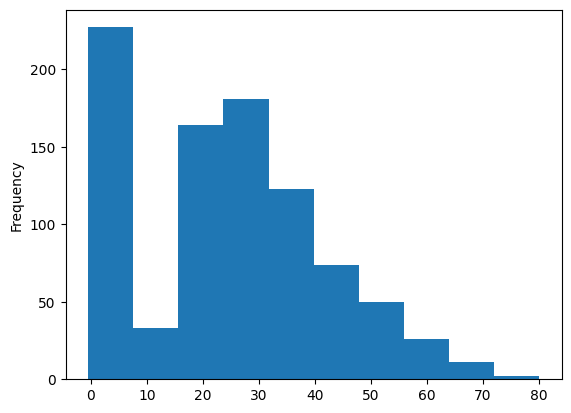

In [25]:
train["Age"].plot(kind="hist")

In [26]:
train[train["Age"]<0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeGroup,CabinBool,Title
5,6,0,3,"Moran, Mr. James",male,-0.5,0,0,8.4583,Q,Desconocido,0,1
17,18,1,2,"Williams, Mr. Charles Eugene",male,-0.5,0,0,13.0000,S,Desconocido,0,1
19,20,1,3,"Masselmani, Mrs. Fatima",female,-0.5,0,0,7.2250,C,Desconocido,0,3
26,27,0,3,"Emir, Mr. Farred Chehab",male,-0.5,0,0,7.2250,C,Desconocido,0,1
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,-0.5,0,0,7.8792,Q,Desconocido,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,-0.5,0,0,7.2292,C,Desconocido,0,1
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,-0.5,8,2,69.5500,S,Desconocido,0,2
868,869,0,3,"van Melkebeke, Mr. Philemon",male,-0.5,0,0,9.5000,S,Desconocido,0,1
878,879,0,3,"Laleff, Mr. Kristo",male,-0.5,0,0,7.8958,S,Desconocido,0,1


In [27]:
train[train["Age"]<1]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeGroup,CabinBool,Title
5,6,0,3,"Moran, Mr. James",male,-0.5,0,0,8.4583,Q,Desconocido,0,1
17,18,1,2,"Williams, Mr. Charles Eugene",male,-0.5,0,0,13.0000,S,Desconocido,0,1
19,20,1,3,"Masselmani, Mrs. Fatima",female,-0.5,0,0,7.2250,C,Desconocido,0,3
26,27,0,3,"Emir, Mr. Farred Chehab",male,-0.5,0,0,7.2250,C,Desconocido,0,1
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,-0.5,0,0,7.8792,Q,Desconocido,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,-0.5,0,0,7.2292,C,Desconocido,0,1
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,-0.5,8,2,69.5500,S,Desconocido,0,2
868,869,0,3,"van Melkebeke, Mr. Philemon",male,-0.5,0,0,9.5000,S,Desconocido,0,1
878,879,0,3,"Laleff, Mr. Kristo",male,-0.5,0,0,7.8958,S,Desconocido,0,1


In [28]:
train[train["Age"]==-0.5]["Title"].value_counts()

Title
1    119
2     36
3     17
4      4
6      1
Name: count, dtype: int64

In [29]:
train[(train["Title"]==4) & (train["Age"] != -0.5)]["Age"].mean()

4.574166666666667

In [30]:
for i in train[train["Age"]==-0.5].index:
  titulo = train.iloc[i]["Title"]
  edad_aproximada = train[(train["Title"] == titulo) & (train["Age"] != -0.5)]["Age"].mean()
  edad_aproximada = round(edad_aproximada)
  train.loc[i, "Age"] = edad_aproximada

<Axes: ylabel='Frequency'>

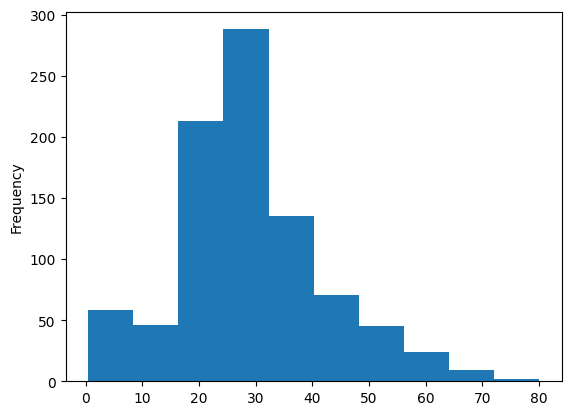

In [31]:
train["Age"].plot(kind="hist")

Ahora que hemos completado los valores faltantes al menos *de alguna manera* precisamente (trabajaré en una mejor manera de predecir los valores de edad faltantes), es hora de asignar a cada grupo de edad un valor numérico.

In [32]:
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
AgeGroup       0
CabinBool      0
Title          0
dtype: int64

### Nombre
Podemos deshacernos de la columna nombre ahora que hemos extraido el valor

In [33]:
# Eliminar la característica de nombre ya que no contiene más información útil.
train = train.drop(['Name'], axis=1)
test = test.drop(['Name'], axis=1)

### Género

In [35]:
# Asignar a cada valor de género un valor numérico
sex_mapping = {"male": 0, "female": 1}
train['Sex'] = train['Sex'].map(sex_mapping)
test['Sex'] = test['Sex'].map(sex_mapping)

train.head()


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeGroup,CabinBool,Title
0,1,0,3,0,22.0,1,0,7.2500,S,Joven,0,1
1,2,1,1,1,38.0,1,0,71.2833,C,Adulto,1,3
2,3,1,3,1,26.0,0,0,7.9250,S,Adulto Joven,0,2
3,4,1,1,1,35.0,1,0,53.1000,S,Adulto Joven,1,3
4,5,0,3,0,35.0,0,0,8.0500,S,Adulto Joven,0,1


### Puerto de embarque

In [36]:
# Asignar a cada valor de Embarque un valor numérico
embarked_mapping = {"S": 1, "C": 2, "Q": 3}
train['Embarked'] = train['Embarked'].map(embarked_mapping)
test['Embarked'] = test['Embarked'].map(embarked_mapping)

train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeGroup,CabinBool,Title
0,1,0,3,0,22.0,1,0,7.2500,1,Joven,0,1
1,2,1,1,1,38.0,1,0,71.2833,2,Adulto,1,3
2,3,1,3,1,26.0,0,0,7.9250,1,Adulto Joven,0,2
3,4,1,1,1,35.0,1,0,53.1000,1,Adulto Joven,1,3
4,5,0,3,0,35.0,0,0,8.0500,1,Adulto Joven,0,1


### Fare Feature
It's time separate the fare values into some logical groups as well as filling in the single missing value in the test dataset.

In [38]:
train["Fare"].isna().sum()

0

In [40]:
test.isna().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           1
Embarked       0
AgeGroup       0
CabinBool      0
Title          0
dtype: int64

In [42]:
# Rellenar los valores faltantes con la media de la tarifa
test["Fare"].fillna(test["Fare"].mean(), inplace=True)

In [44]:
test.isna().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
AgeGroup       0
CabinBool      0
Title          0
dtype: int64

In [48]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeGroup,CabinBool,Title
0,1,0,3,0,22.0,1,0,7.2500,1,Joven,0,1
1,2,1,1,1,38.0,1,0,71.2833,2,Adulto,1,3
2,3,1,3,1,26.0,0,0,7.9250,1,Adulto Joven,0,2
3,4,1,1,1,35.0,1,0,53.1000,1,Adulto Joven,1,3
4,5,0,3,0,35.0,0,0,8.0500,1,Adulto Joven,0,1


In [49]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeGroup,CabinBool,Title
0,892,3,0,34.5,0,0,7.8292,3,Adulto Joven,0,1
1,893,3,1,47.0,1,0,7.0000,1,Adulto,0,3
2,894,2,0,62.0,0,0,9.6875,3,Adulto Mayor,0,1
3,895,3,0,27.0,0,0,8.6625,1,Adulto Joven,0,1
4,896,3,1,22.0,1,1,12.2875,1,Joven,0,3


### Buscando el mejor modelo

### Dividir el conjunto de entrenamiento en 2 partes
Utilizaremos parte de nuestros datos de entrenamiento (en este caso, el 22%) para probar la precisión de nuestros diferentes modelos.


In [56]:
# Codificando el grupo de edad
train = pd.get_dummies(train, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

In [57]:
from sklearn.model_selection import train_test_split

predictors = train.drop(['Survived', 'PassengerId'], axis=1)
target = train["Survived"]
x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size = 0.2, random_state = 0)

### Probando diferentes modelos

Probaremos los siguientes modelos

* Naive Bayes Gaussiano
* Regresión Logística
* Máquinas de Vectores de Soporte
* Perceptrón
* Clasificador de Árbol de Decisión
* Clasificador de Bosque Aleatorio
* KNN o Vecinos más Cercanos
* Descenso de Gradiente Estocástico
* Clasificador de Refuerzo de Gradiente

Para cada modelo, establecemos el modelo, lo ajustamos con el 80% de nuestros datos de entrenamiento, predecimos para el 20% de los datos de entrenamiento y comprobamos la precisión.


In [58]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
y_pred = gaussian.predict(x_val)
acc_gaussian = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_gaussian)

78.77


In [59]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_val)
acc_logreg = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_logreg)

77.65


In [60]:
# Support Vector Machines
from sklearn.svm import SVC

svc = SVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_val)
acc_svc = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_svc)

72.63


In [61]:
# Linear SVC
from sklearn.svm import LinearSVC

linear_svc = LinearSVC()
linear_svc.fit(x_train, y_train)
y_pred = linear_svc.predict(x_val)
acc_linear_svc = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_linear_svc)

69.27


In [62]:
# Perceptron
from sklearn.linear_model import Perceptron

perceptron = Perceptron()
perceptron.fit(x_train, y_train)
y_pred = perceptron.predict(x_val)
acc_perceptron = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_perceptron)

76.54


In [63]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

decisiontree = DecisionTreeClassifier()
decisiontree.fit(x_train, y_train)
y_pred = decisiontree.predict(x_val)
acc_decisiontree = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_decisiontree)

79.89


In [64]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier()
randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_val)
acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_randomforest)

83.24


In [65]:
# KNN or k-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_val)
acc_knn = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_knn)

74.3


In [66]:
# Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(x_train, y_train)
y_pred = sgd.predict(x_val)
acc_sgd = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_sgd)

70.39


In [67]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

gbk = GradientBoostingClassifier()
gbk.fit(x_train, y_train)
y_pred = gbk.predict(x_val)
acc_gbk = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_gbk)

83.24


Let's compare the accuracies of each model!

In [68]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression',
              'Random Forest', 'Naive Bayes', 'Perceptron', 'Linear SVC',
              'Decision Tree', 'Stochastic Gradient Descent', 'Gradient Boosting Classifier'],
    'Score': [acc_svc, acc_knn, acc_logreg,
              acc_randomforest, acc_gaussian, acc_perceptron,acc_linear_svc, acc_decisiontree,
              acc_sgd, acc_gbk]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,83.24
9,Gradient Boosting Classifier,83.24
7,Decision Tree,79.89
4,Naive Bayes,78.77
2,Logistic Regression,77.65
5,Perceptron,76.54
1,KNN,74.30
0,Support Vector Machines,72.63
8,Stochastic Gradient Descent,70.39
6,Linear SVC,69.27


Seleccionamos el Random Forest

## Predecir!

<Axes: xlabel='Predictions'>

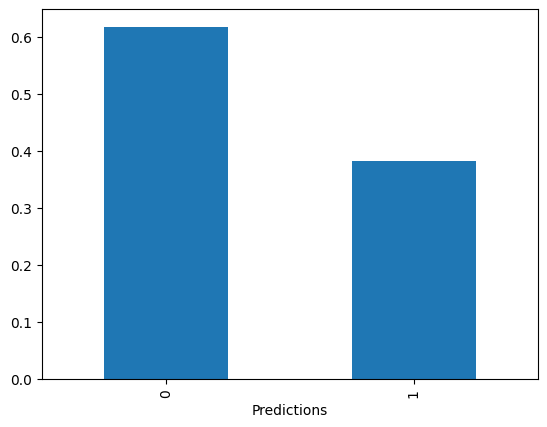

In [78]:
#set ids as PassengerId and predict survival
ids = test['PassengerId']
inputs = test.drop('PassengerId', axis=1)
predictions = randomforest.predict(test.drop('PassengerId', axis=1))

#set the output as a dataframe and convert to csv file named submission.csv
inputs["Predictions"] = predictions

inputs["Predictions"].value_counts(1).plot(kind="bar")

## Felicidades !!!!